# Contribute Proportional to Trust With Weighted Average Ensemble

A weighted average ensemble is an approach that allows multiple models to contribute to a prediction in proportion to their trust or estimated performance. A modeling averaging ensemble combines the prediction from each model equally and often results in better performance on average than a given single model. Sometimes there are very good models that we wish to contribute more to an ensemble prediction, and perhaps less skillful models that may be useful but should contribute less to an ensemble prediction. In this tutorial, you will discover how to develop a weighted average ensemble of deep learning neural network models in Python with Keras. After completing this tutorial, you will know:

* Model averaging ensembles are limited because they require that each ensemble member contribute equally to predictions.
* Weighted average ensembles allow the contribution of each ensemble member to a prediction to be weighted proportionally to the trust or performance of the member on a holdout dataset.
* How to implement a weighted average ensemble in Keras and compare results to a model averaging ensemble and standalone models.

## Weighted Average Ensemble

Model averaging is an approach to ensemble learning where each ensemble member contributes an equal amount to the final prediction. In the case of regression, the ensemble prediction is calculated as the average of the member predictions. In the case of predicting a class label, the prediction is calculated as the mode of the member predictions. In the case of predicting a class probability, the prediction can be calculated as the argmax of the summed probabilities for each class label. A limitation of this approach is that each model has an equal contribution to the final prediction made by the ensemble. There is a requirement that all ensemble members have the skill compared to random chance, although some models are known to perform much better or much worse than others.

A weighted ensemble is an extension of a model averaging ensemble where the model's performance weights the contribution of each member to the final prediction. The model weights are small positive values, and the sum of all weights equals one, allowing the weights to indicate the percentage of trust or expected performance from each model.

Uniform values for the weights (e.g., $ \frac{1}{k} $ where k is the number of ensemble members) mean that the weighted ensemble acts as a simple averaging ensemble. There is no analytical solution to finding the weights (we cannot calculate them); instead, the value for the weights can be estimated using either the training dataset or a holdout validation dataset. Finding the weights using the same training set used to fit the ensemble members will likely result in an overfit model. A more robust approach is to use a holdout validation dataset unseen by the ensemble members during training.

The simplest, perhaps most exhaustive approach would be to grid search weight values between 0 and 1 for each ensemble member. Alternately, an optimization procedure such as a linear solver or gradient descent optimization can be used to estimate the weights using a unit norm weight constraint to ensure that the vector of weights sum to one. Unless the holdout validation dataset is large and representative, a weighted ensemble can overfit compared to a simple averaging ensemble. A simple alternative to adding more weight to a given model without calculating explicit weight coefficients is to add a given model more than once to the ensemble. Although less flexible, it allows a given well-performing model to contribute more than once to a given prediction made by the ensemble.

## Weighted Average Ensemble Case Study

In this section, we will demonstrate how to use the weighted average ensemble to reduce the variance of an MLP on a simple multiclass classification problem. This example provides a template for applying the weighted average ensemble to your neural network for classification and regression problems.

### Multiclass Classification Problem

We will use a small multiclass classification problem as the basis to demonstrate the weighted averaging ensemble. The scikit-learn class provides the `make_blobs()` function that can be used to create a multiclass classification problem with the prescribed number of samples, input variables, classes, and variance of samples within a class. The problem can be configured to have two input variables (to represent the x and y coordinates of the points) and a standard deviation of 2.0 for points within each group. We will use the same random state (seed for the pseudorandom number generator) to ensure that we always get the same data points.

In [2]:
from sklearn.datasets import make_blobs

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

The results are the input and output elements of a dataset that we can model. In order to get a feeling for the complexity of the problem, we can graph each point on a two-dimensional scatter plot and color each point by class value. The complete example is listed below.

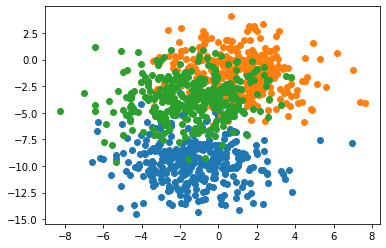

In [3]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

# scatter plot for each class value
for class_value in range(3):
    # select indices of points with the class label
    row_ix = where(y == class_value)

    # scatter plot for points with a different color
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])

# show plot
pyplot.show()

Running the example creates a scatter plot of the entire dataset. We can see that the standard deviation of 2.0 means that the classes are not linearly separable (separable by a line), causing many ambiguous points. This is desirable because the problem is non-trivial and will allow a neural network model to find many different *good enough* candidate solutions resulting in a high variance.

### Multilayer Perceptron Model

Before we define a model, we need to contrive an appropriate problem for the weighted average ensemble. In our problem, the training dataset is relatively small. Specifically, there is a 10:1 ratio of examples in the training dataset to the holdout dataset. This mimics a situation where we may have a vast number of unlabeled examples and a small number of labeled examples with which to train a model. We will create 1,100 data points from the blobs problem. The model will be trained on the first 100 points, and the remaining 1,000 will be held back in a test dataset, unavailable to the model.

The problem is a multiclass classification problem, and we will model it using a softmax activation function on the output layer. This means that the model will predict a vector with three elements with the probability that the sample belongs to each of the three classes. Therefore, the first step is to one-hot encode the class values.

In [4]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (1000, 2)


Next, we can define and compile the model. The model will expect samples with two input variables. The model then has a single hidden layer with 25 nodes and a rectified linear activation function, an output layer with three nodes to predict the probability of each of the three classes, and a softmax activation function. Because the problem is multiclass, we will use the categorical cross-entropy loss function to optimize the model and the efficient Adam flavor of stochastic gradient descent.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The model is fit for 500 training epochs, and we will evaluate each epoch on the test set, using the test set as a validation set.

In [6]:
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=1)

Epoch 1/500
4/4 [==============================] - 1s 90ms/step - loss: 1.2299 - accuracy: 0.3485 - val_loss: 1.2978 - val_accuracy: 0.3330
Epoch 2/500
4/4 [==============================] - 0s 19ms/step - loss: 1.2624 - accuracy: 0.3568 - val_loss: 1.2512 - val_accuracy: 0.3330
Epoch 3/500
4/4 [==============================] - 0s 16ms/step - loss: 1.2251 - accuracy: 0.3256 - val_loss: 1.2113 - val_accuracy: 0.3340
Epoch 4/500
4/4 [==============================] - 0s 16ms/step - loss: 1.1625 - accuracy: 0.3579 - val_loss: 1.1778 - val_accuracy: 0.3350
Epoch 5/500
4/4 [==============================] - 0s 15ms/step - loss: 1.1136 - accuracy: 0.3725 - val_loss: 1.1491 - val_accuracy: 0.3360
Epoch 6/500
4/4 [==============================] - 0s 15ms/step - loss: 1.0989 - accuracy: 0.3527 - val_loss: 1.1248 - val_accuracy: 0.3380
Epoch 7/500
4/4 [==============================] - 0s 15ms/step - loss: 1.1074 - accuracy: 0.3527 - val_loss: 1.1029 - val_accuracy: 0.3410
Epoch 8/500
4/4 [===

4/4 [==============================] - 0s 15ms/step - loss: 0.6298 - accuracy: 0.7385 - val_loss: 0.6694 - val_accuracy: 0.7160
Epoch 60/500
4/4 [==============================] - 0s 15ms/step - loss: 0.6133 - accuracy: 0.7677 - val_loss: 0.6657 - val_accuracy: 0.7170
Epoch 61/500
4/4 [==============================] - 0s 15ms/step - loss: 0.6093 - accuracy: 0.7884 - val_loss: 0.6622 - val_accuracy: 0.7230
Epoch 62/500
4/4 [==============================] - 0s 16ms/step - loss: 0.6018 - accuracy: 0.7863 - val_loss: 0.6594 - val_accuracy: 0.7210
Epoch 63/500
4/4 [==============================] - 0s 15ms/step - loss: 0.6012 - accuracy: 0.7469 - val_loss: 0.6570 - val_accuracy: 0.7270
Epoch 64/500
4/4 [==============================] - 0s 16ms/step - loss: 0.6244 - accuracy: 0.7095 - val_loss: 0.6543 - val_accuracy: 0.7270
Epoch 65/500
4/4 [==============================] - 0s 16ms/step - loss: 0.5551 - accuracy: 0.7700 - val_loss: 0.6511 - val_accuracy: 0.7270
Epoch 66/500
4/4 [========

4/4 [==============================] - 0s 15ms/step - loss: 0.4756 - accuracy: 0.7936 - val_loss: 0.5722 - val_accuracy: 0.7670
Epoch 118/500
4/4 [==============================] - 0s 15ms/step - loss: 0.5020 - accuracy: 0.7590 - val_loss: 0.5718 - val_accuracy: 0.7620
Epoch 119/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4997 - accuracy: 0.7695 - val_loss: 0.5708 - val_accuracy: 0.7620
Epoch 120/500
4/4 [==============================] - 0s 14ms/step - loss: 0.5004 - accuracy: 0.7497 - val_loss: 0.5693 - val_accuracy: 0.7630
Epoch 121/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4830 - accuracy: 0.7820 - val_loss: 0.5666 - val_accuracy: 0.7760
Epoch 122/500
4/4 [==============================] - 0s 15ms/step - loss: 0.5209 - accuracy: 0.7488 - val_loss: 0.5649 - val_accuracy: 0.7770
Epoch 123/500
4/4 [==============================] - 0s 15ms/step - loss: 0.5180 - accuracy: 0.7540 - val_loss: 0.5647 - val_accuracy: 0.7750
Epoch 124/500
4/4 [=

Epoch 175/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4228 - accuracy: 0.8249 - val_loss: 0.5255 - val_accuracy: 0.7850
Epoch 176/500
4/4 [==============================] - 0s 16ms/step - loss: 0.4300 - accuracy: 0.8353 - val_loss: 0.5249 - val_accuracy: 0.7850
Epoch 177/500
4/4 [==============================] - 0s 17ms/step - loss: 0.4593 - accuracy: 0.8030 - val_loss: 0.5253 - val_accuracy: 0.7820
Epoch 178/500
4/4 [==============================] - 0s 16ms/step - loss: 0.4399 - accuracy: 0.8238 - val_loss: 0.5249 - val_accuracy: 0.7830
Epoch 179/500
4/4 [==============================] - 0s 16ms/step - loss: 0.4514 - accuracy: 0.8092 - val_loss: 0.5234 - val_accuracy: 0.7850
Epoch 180/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4404 - accuracy: 0.8238 - val_loss: 0.5218 - val_accuracy: 0.7810
Epoch 181/500
4/4 [==============================] - 0s 16ms/step - loss: 0.4439 - accuracy: 0.8145 - val_loss: 0.5201 - val_accuracy: 0.7820
Epoch 

Epoch 233/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3934 - accuracy: 0.8353 - val_loss: 0.4866 - val_accuracy: 0.8000
Epoch 234/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4203 - accuracy: 0.7990 - val_loss: 0.4858 - val_accuracy: 0.8010
Epoch 235/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4199 - accuracy: 0.7750 - val_loss: 0.4851 - val_accuracy: 0.8020
Epoch 236/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3664 - accuracy: 0.8334 - val_loss: 0.4844 - val_accuracy: 0.8030
Epoch 237/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4171 - accuracy: 0.8240 - val_loss: 0.4838 - val_accuracy: 0.8030
Epoch 238/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4025 - accuracy: 0.8032 - val_loss: 0.4837 - val_accuracy: 0.8030
Epoch 239/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4103 - accuracy: 0.8021 - val_loss: 0.4847 - val_accuracy: 0.8010
Epoch 

Epoch 291/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4006 - accuracy: 0.7990 - val_loss: 0.4671 - val_accuracy: 0.8080
Epoch 292/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3692 - accuracy: 0.8084 - val_loss: 0.4667 - val_accuracy: 0.8090
Epoch 293/500
4/4 [==============================] - 0s 14ms/step - loss: 0.3379 - accuracy: 0.8429 - val_loss: 0.4662 - val_accuracy: 0.8090
Epoch 294/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3932 - accuracy: 0.7929 - val_loss: 0.4658 - val_accuracy: 0.8110
Epoch 295/500
4/4 [==============================] - 0s 14ms/step - loss: 0.3878 - accuracy: 0.8033 - val_loss: 0.4655 - val_accuracy: 0.8100
Epoch 296/500
4/4 [==============================] - 0s 14ms/step - loss: 0.3786 - accuracy: 0.7877 - val_loss: 0.4654 - val_accuracy: 0.8060
Epoch 297/500
4/4 [==============================] - 0s 14ms/step - loss: 0.3923 - accuracy: 0.7773 - val_loss: 0.4654 - val_accuracy: 0.8060
Epoch 

Epoch 349/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3692 - accuracy: 0.8257 - val_loss: 0.4630 - val_accuracy: 0.8000
Epoch 350/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3470 - accuracy: 0.8495 - val_loss: 0.4624 - val_accuracy: 0.7990
Epoch 351/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3877 - accuracy: 0.8266 - val_loss: 0.4621 - val_accuracy: 0.7990
Epoch 352/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3570 - accuracy: 0.8330 - val_loss: 0.4616 - val_accuracy: 0.8010
Epoch 353/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3461 - accuracy: 0.8362 - val_loss: 0.4616 - val_accuracy: 0.8010
Epoch 354/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3485 - accuracy: 0.8311 - val_loss: 0.4628 - val_accuracy: 0.8020
Epoch 355/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3409 - accuracy: 0.8238 - val_loss: 0.4633 - val_accuracy: 0.8000
Epoch 

Epoch 407/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3250 - accuracy: 0.8382 - val_loss: 0.4600 - val_accuracy: 0.8020
Epoch 408/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3672 - accuracy: 0.8153 - val_loss: 0.4579 - val_accuracy: 0.8030
Epoch 409/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3421 - accuracy: 0.8329 - val_loss: 0.4570 - val_accuracy: 0.8050
Epoch 410/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3296 - accuracy: 0.8622 - val_loss: 0.4565 - val_accuracy: 0.8040
Epoch 411/500
4/4 [==============================] - 0s 17ms/step - loss: 0.3608 - accuracy: 0.8060 - val_loss: 0.4560 - val_accuracy: 0.8030
Epoch 412/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3661 - accuracy: 0.8245 - val_loss: 0.4557 - val_accuracy: 0.8040
Epoch 413/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3328 - accuracy: 0.8570 - val_loss: 0.4560 - val_accuracy: 0.8030
Epoch 

Epoch 465/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3161 - accuracy: 0.8507 - val_loss: 0.4569 - val_accuracy: 0.8090
Epoch 466/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3003 - accuracy: 0.8549 - val_loss: 0.4572 - val_accuracy: 0.8050
Epoch 467/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3518 - accuracy: 0.8339 - val_loss: 0.4562 - val_accuracy: 0.8060
Epoch 468/500
4/4 [==============================] - 0s 15ms/step - loss: 0.2828 - accuracy: 0.8848 - val_loss: 0.4557 - val_accuracy: 0.8050
Epoch 469/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3177 - accuracy: 0.8773 - val_loss: 0.4557 - val_accuracy: 0.8060
Epoch 470/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3334 - accuracy: 0.8452 - val_loss: 0.4570 - val_accuracy: 0.8050
Epoch 471/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3498 - accuracy: 0.8400 - val_loss: 0.4573 - val_accuracy: 0.8040
Epoch 

At the end of the run, we will evaluate the model's performance on both the train and the test sets.

In [8]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.840, Test: 0.814


Then finally, we will plot model loss and accuracy learning curves over each training epoch on both the training and test dataset.

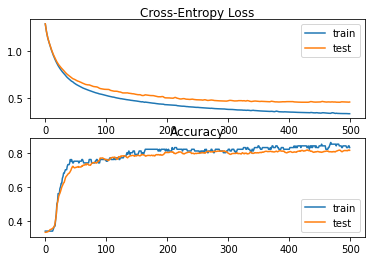

In [9]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

The complete example is listed below.

In [10]:
# fit high variance mlp on blobs classification problem
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

#define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.830, Test: 0.797


Running the example, it first prints the performance of the final model on the train and test datasets.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that the model achieved about 85% accuracy on the training dataset, which we know is optimistic, and about 80% on the test dataset, which we would expect to be more realistic.

A line plot also shows the learning curves for the model loss and accuracy on the train and test sets over each training epoch. We can see that training accuracy is more optimistic over most of the run, as we noted with the final scores.

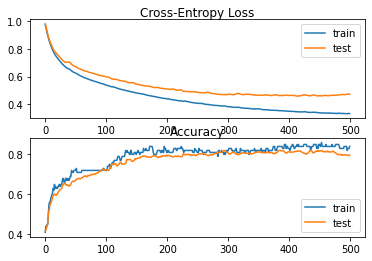

In [11]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

Now that we have identified that the model is a good candidate for developing an ensemble, we can next look at developing a simple model averaging ensemble.

### Model Averaging Ensemble

### Grid Search Weighted Average Ensemble

### Weighted Average MLP Ensemble

## Extensions

This section lists some ideas for extending the tutorial that you may wish to explore.

* **Parallelize Grid Search**. Update the grid search example to use the Joblib library to parallelize weight evaluation.
* **Implement Random Search**. Update the grid search example to use a random search of weight coefficients.
* **Try a Local Search**. Try a local search procedure provided by the SciPy library instead of the global search and compare performance.
* **Repeat Global Optimization**. Repeat the global optimization procedure multiple times for a given set of models to see if differing sets of weights can be found across the runs.

## Summary

In this tutorial, you discovered how to develop a weighted average ensemble of deep learning neural network models in Python with Keras. Specifically, you learned:

* Model averaging ensembles are limited because they require that each ensemble member contribute equally to predictions.
* Weighted average ensembles allow the contribution of each ensemble member to a prediction to be weighted proportionally to the trust or performance of the member on a holdout dataset.
* How to implement a weighted average ensemble in Keras and compare results to a model averaging ensemble and standalone models.